<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook: https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question: https://github.com/mrdbourke/pytorch-deep-learing/discussions

In [1]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from pathlib import Path
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.
* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 4))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

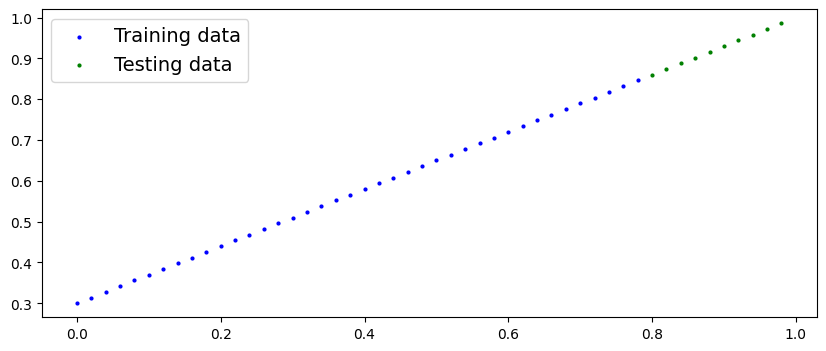

In [7]:
plot_predictions()

## 2. Build model

Our first PyTorch Model

This is very exciting... let's do it!

Because we're going to be building classes throughout the couse, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):  # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(
            1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(
            1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # "x" is the input data
        return self.weights * x + self.bias  # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs(a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optmin - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite foward(), this method defines what happens in the forward computation

See more on these essential modeuls via the PyTorch cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of your PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`.

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the forward() method.

In [11]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, inference_mode is preferred
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here: https://twitter.com/PyTorch/status/1437838231505096708

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

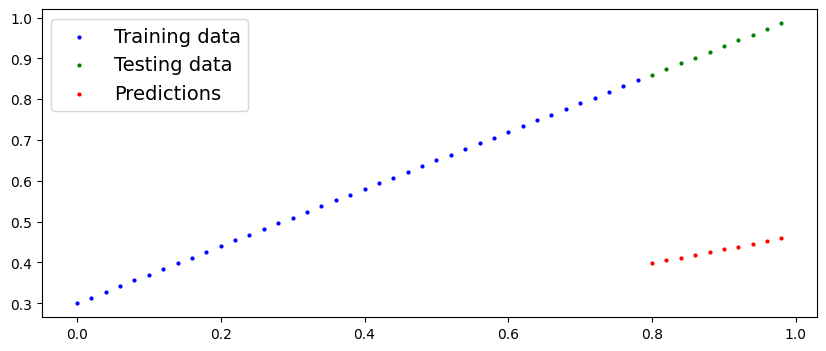

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these ma be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are, is to use a loss function.


* Note: Loss function may also e called cost function or criterion in different areas. For our cases, we're going to refer to it as a loss function.

This we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function: https://pytorch.org/docs/stable/optim.html/#module-torch.optim
    * Inside the optimizer you'll often hae to set two parameters:
        * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
        * `lr`(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# Check out our model's parameters (a parameter is a vlaue that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(
    params=model_0.parameters(),  # we want to optimize the parameters present in our model
    lr=0.01)  # lr (i.e. learning rate), possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?
**A:** This will be problem specific. But with experience, you'll get an ideia of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like cassifying whether a photo is of a dog or a cat, you'll want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data do...;
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation;
2. Calculate the loss (compare forward pass predictions to ground truth labels);
3. Optimizer zero grad;
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our models with respect to the loss (**backpropagation**);
5. Optimizer step - user the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**);



In [17]:
# Create a random seed
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that requires gradients to require gradiets

    # 1. Foward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()  # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    # Set the model to testing mode
    model_0.eval()  # turns off different settings in the model not needed for evaluation/testing

    with torch.inference_mode():  # turns off gradient tracking & a couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        print(f"\nEpoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

        # Print out model state_dict()
        print(f"{model_0.state_dict()}")



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])

Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])

Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])

Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])

Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])

Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])

Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

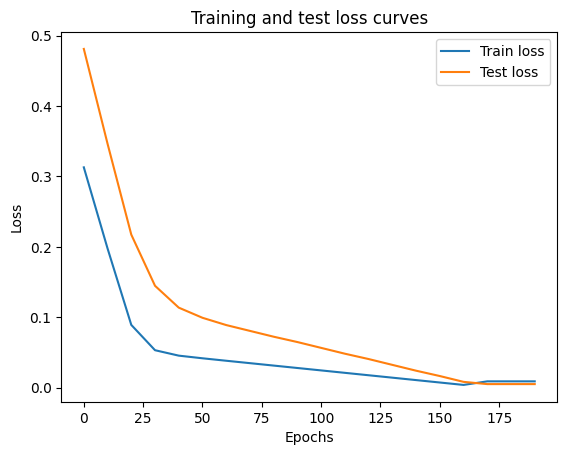

In [18]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()) , label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [19]:
weight, bias

(0.7, 0.3)

In [20]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

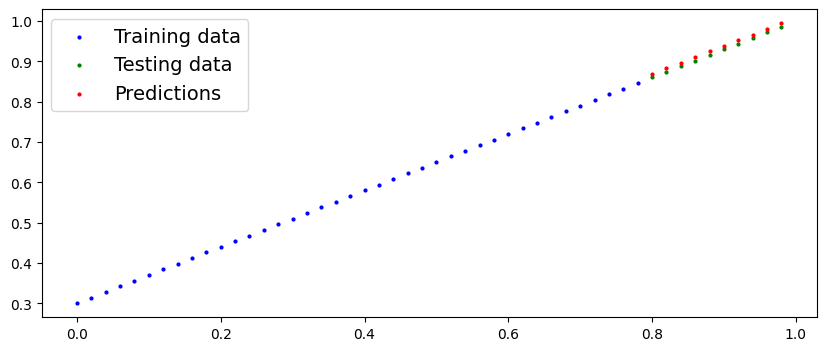

In [21]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods you should known about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format.
2. `torch.load()` - allows you to load a saved a PyTorch object.
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary.

PyTorch save & load code tutorial + extra-curriculum:
 https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [22]:
# Saving our PyTorch model
# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [23]:
!ls -l models

total 8
-rw-r--r-- 1 root root 1207 Sep  9 20:41 01_pytorch_workflow_model_0.pth
-rw-r--r-- 1 root root 1271 Sep  9 20:33 01_pytorch_workflow_model_1.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with update parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_pred = loaded_model_0(X_test)

In [28]:
# Compare loaded model preds with original model preds
test_pred == loaded_model_0_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [29]:
# Import PyTorch and matplotlib
import matplotlib.pyplot as plt
import torch

from torch import nn

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [30]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [31]:
!nvidia-smi

Sat Sep  9 20:42:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 6.1 Data

In [32]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features ans labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [33]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

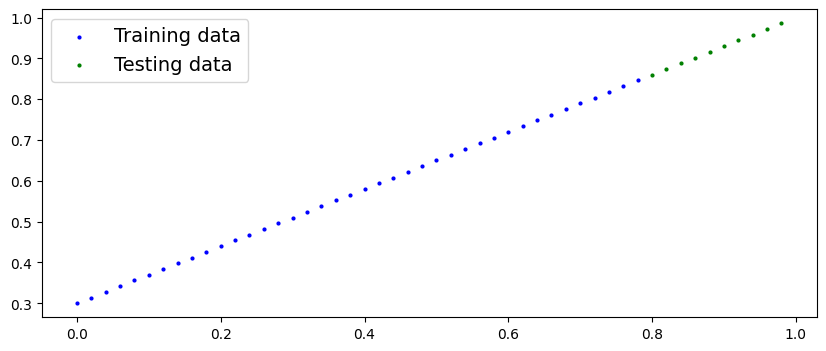

In [34]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

In [35]:
# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

### 6.2 Build a PyTorch Linear model

In [36]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        # User nn.Linear() for creating the model parameters / also called: linear transform, probin layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [37]:
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [38]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [39]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [40]:
# Setup loss function
loss_fn = nn.L1Loss()  # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01)

In [41]:
# Let's write a training loop
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
    model_1.train()

    # 1. Forward_pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [42]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [43]:
# Turn model into evaluaion mode
model_1. eval()

# Make predictions on the test data
with torch.inference_mode():
    y_pred = model_1(X_test)

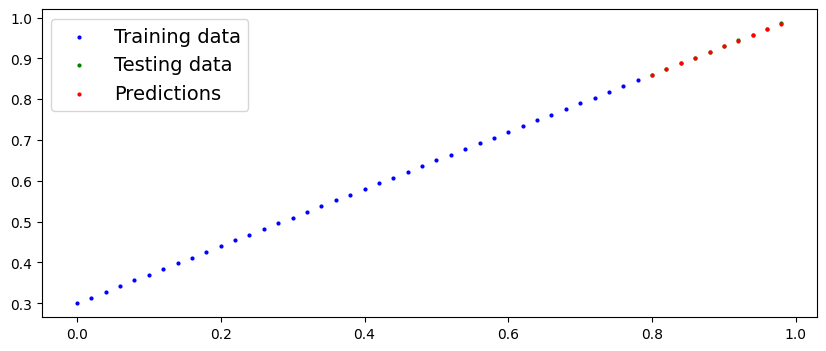

In [44]:
# Check out our model predictions visually
plot_predictions(predictions=y_pred.cpu())

### 6.5 Saving & loading a trained model

In [45]:
from pathlib import Path

# 1. Create model dictory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [46]:
# Load a PyTorch

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [47]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [48]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [49]:
# Evaulated loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_pred = loaded_model_1(X_test)

y_pred == loaded_model_1_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')